In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-electricity-consumption-and-production/electricityConsumptionAndProductioction.csv


# Overview

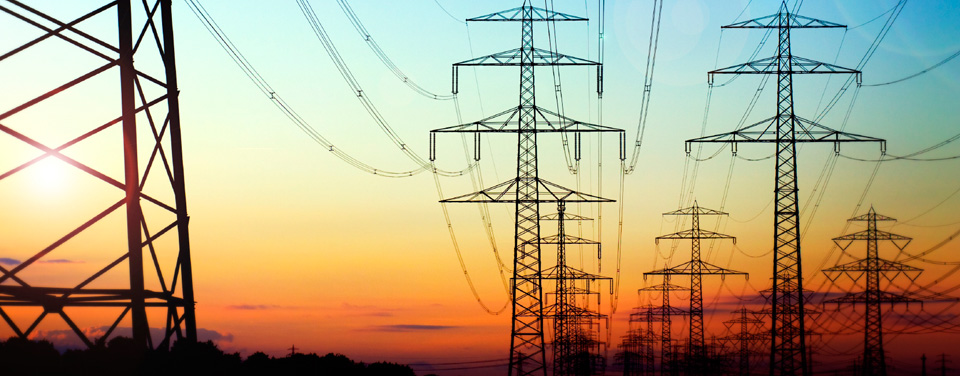

We have a timeseries dataset and we want to do a forecast for the last section of it. The time series we will use is the electricity consumptio for Romania. 

A more in depth look at this dataset can be found [here](https://www.kaggle.com/code/stefancomanita/electricity-consumption-production-visualization). It is well worth taking a look, as here we will look at a small part of it, meaning the consumption aspect.

For the forcast we will first use a simple regression done with XGBost, and the we will try the same forecast using the Prophet library from Facebook/Meta.

For both solutions we will pretty much do an "out of the box" approach, meaning not much costumization was done (yeah, I am lazy like that) but we will make some nice graphs in order to make up :)

# Imports

Nothing really fancy, just notice that we import XGBost and Prophet.

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from prophet import Prophet

# Loading the data and minor EDA

We load the data and set the index to be the DateTime column of the dataset.

In [57]:
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)

df = pd.read_csv("/kaggle/input/hourly-electricity-consumption-and-production/electricityConsumptionAndProductioction.csv")
df.head()

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


In [58]:
df = df.set_index("DateTime")
df.head()

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
DateTime,,,,,,,,,
2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


In [59]:

# set the DateTime as the index

df.index = pd.to_datetime(df.index)
df.head()

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
DateTime,,,,,,,,,
2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


Now let us print the shape fo our data set and also it's head.

In [60]:
print(f"our shape is {df.shape}")
print()
df.head()

our shape is (36772, 9)



,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
DateTime,,,,,,,,,
2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


We attempt to predict the electricity consumption, so we will drop all the columns except the Consumption (and the DateTime which is now our index).

In [61]:
df.drop(["Production", "Nuclear", "Wind", "Hydroelectric", "Oil and Gas", "Coal", "Solar", "Biomass"], axis=1, inplace=True)

Now let's do a plot in order to the see the data and determine if it has apttern that we can forecast.
We will plot out entiere data set.

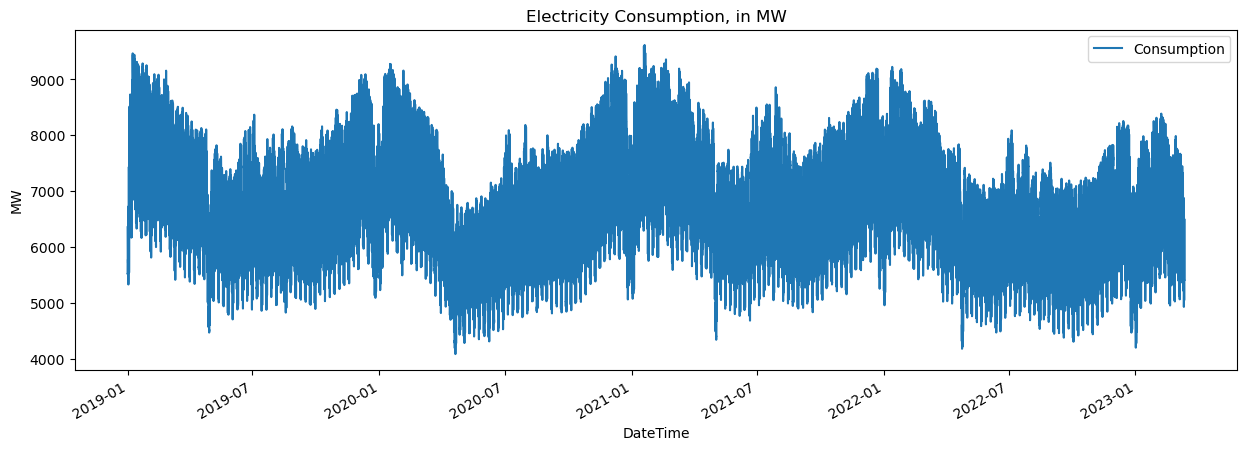

In [62]:
df[["Consumption"]].plot(style="-", figsize=(15, 5), title="Electricity Consumption, in MW")
plt.ylabel('MW')
plt.show()

Excelent, we can see that our entire dataste (of 4 and a half years) has a seasonality to it.

Now let us plot just a week, to see if the seasonality checks up.

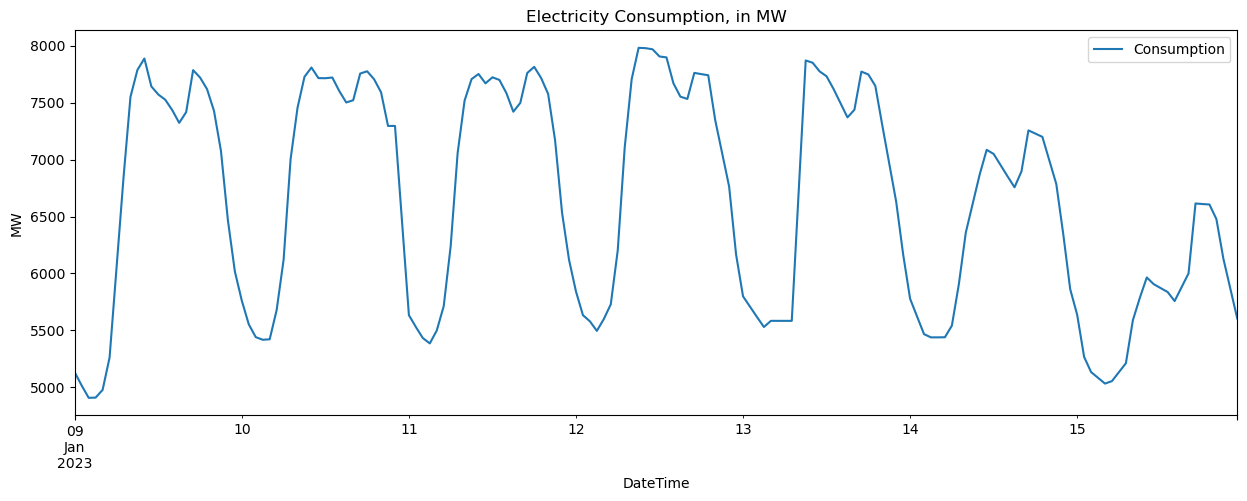

In [63]:
df["2023-01-09 00:00:00" : "2023-01-15 23:59:59"][["Consumption"]].plot(style="-", figsize=(15, 5), title="Electricity Consumption, in MW")
plt.ylabel('MW')
plt.show()

Great, we can see that our data has a very nice seasonality to it also at the week level.

# Types of forecastable data

In order for us to be able to forecast the time series it must have a predictable pattern. The most common time series patterns can be seen in the image bellow.

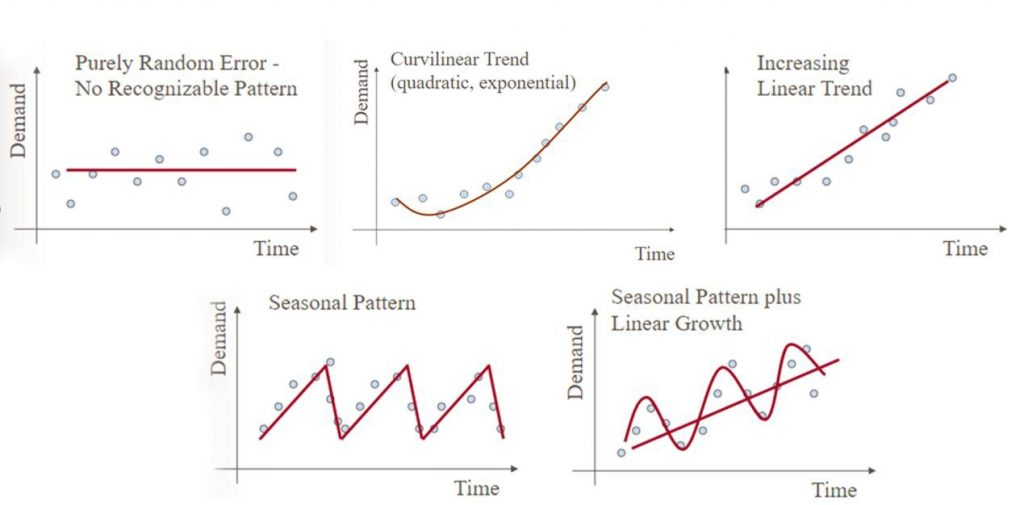

By looking at the presented picture and our previous plots we can definatly say we have a seasonale pattern in our dataset nad this makes it very forecastable.

# Add features and split the datain train and test sets

First let as add some new features that are derived hout the DateTime index.

In [64]:
# method for adding time features by the time index
def createTimeFeatures(df):
    df["hour"] = df.index.hour
    df["day_of_week"] = df.index.day_of_week
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["day_of_year"] = df.index.dayofyear


# apply the method to the existing dataframe
createTimeFeatures(df)

print(df.shape)
df.tail()

(36772, 7)


,Consumption,hour,day_of_week,quarter,month,year,day_of_year
DateTime,,,,,,,
2023-03-12 19:00:00,6500,19,6,1,3,2023,71
2023-03-12 20:00:00,6471,20,6,1,3,2023,71
2023-03-12 21:00:00,6194,21,6,1,3,2023,71
2023-03-12 22:00:00,5708,22,6,1,3,2023,71
2023-03-12 23:00:00,5409,23,6,1,3,2023,71


Now let us split the data, we will use the last year as our dataset.

Do also a simple plot to see as a graph what is the percentage of the train versus datasets. A red vetical line will represent the split.

In [65]:
df.head()

,Consumption,hour,day_of_week,quarter,month,year,day_of_year
DateTime,,,,,,,
2019-01-01 00:00:00,6352,0,1,1,1,2019,1
2019-01-01 01:00:00,6116,1,1,1,1,2019,1
2019-01-01 02:00:00,5873,2,1,1,1,2019,1
2019-01-01 03:00:00,5682,3,1,1,1,2019,1
2019-01-01 04:00:00,5557,4,1,1,1,2019,1


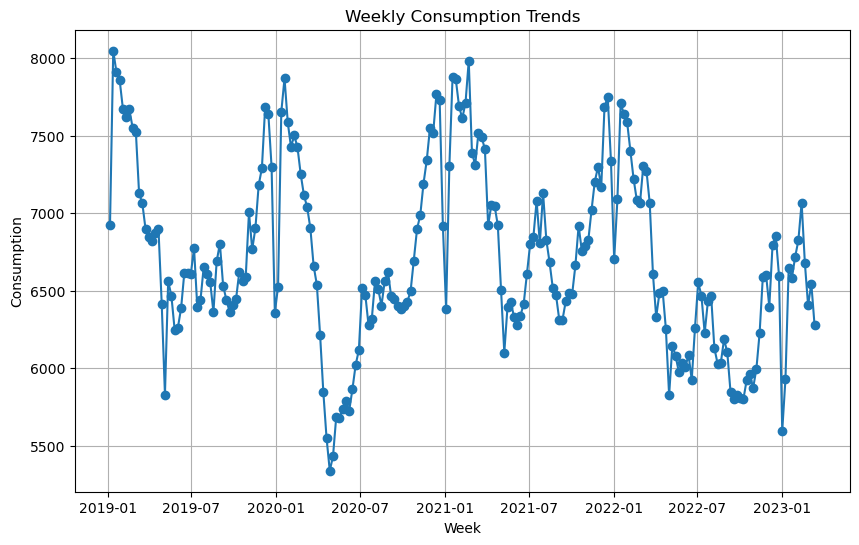

In [66]:
# Resample the data on a weekly basis and calculate the mean consumption for each week
weekly_data = df['Consumption'].resample('W').mean()

# Plotting consumption trends on a weekly basis
plt.figure(figsize=(10, 6))
plt.plot(weekly_data.index, weekly_data.values, marker='o', linestyle='-')
plt.title('Weekly Consumption Trends')
plt.xlabel('Week')
plt.ylabel('Consumption')
plt.grid(True)
plt.show()

cutOffDate 2022-03-13 01:00:00
train size: 28013 and test 8759 and toal dataset: 36772


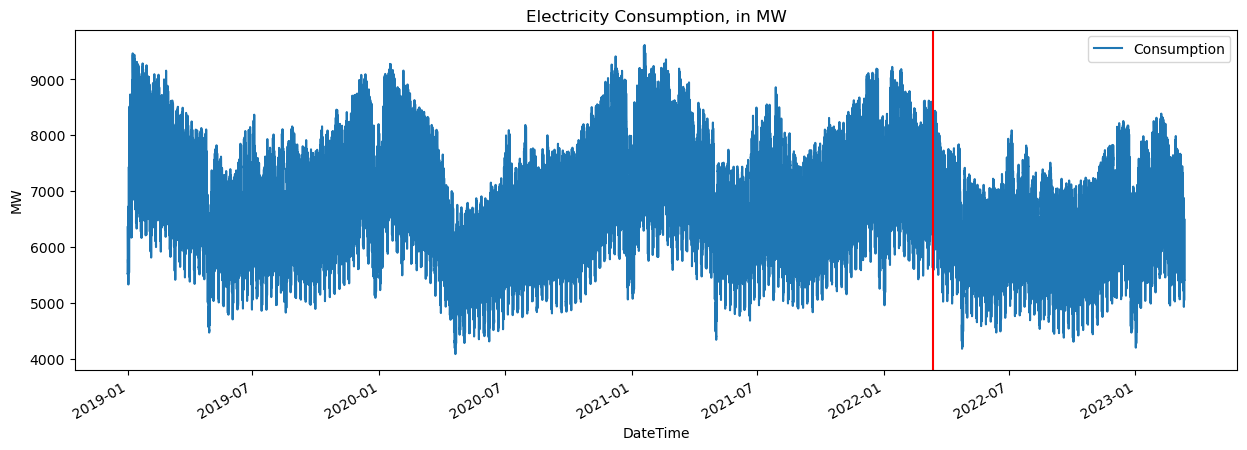

In [67]:
cutOffDate = df.index[-365 * 24]
print(f"cutOffDate {cutOffDate}")

train = df.loc[df.index <= cutOffDate]
test = df.loc[df.index > cutOffDate]

print(f"train size: {len(train)} and test {len(test)} and toal dataset: {len(train) + len(test)}")

df[["Consumption"]].plot(style="-", figsize=(15, 5), title="Electricity Consumption, in MW")
plt.ylabel('MW')
plt.axvline(x=cutOffDate, color='r')
plt.show()

Cool, now we have augmented our dataframe with some new features and we have split the dataframe in train and test.

# Create simple method for calculating the error

We want to create a simple method that will show the error betwne the actual value and predicted value as a percentage.

In [68]:
def meanAbsolutErrorAaPercentage(real, predicted):
    real = np.array(real)
    predicted = np.array(predicted)

    return np.mean(np.abs((real - predicted) / real)) * 100

# ARIMA Model

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


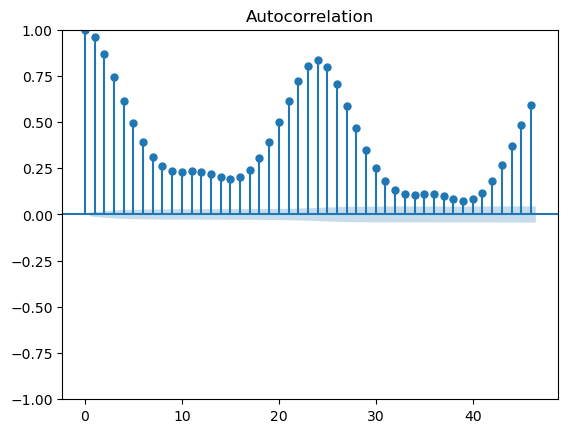

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


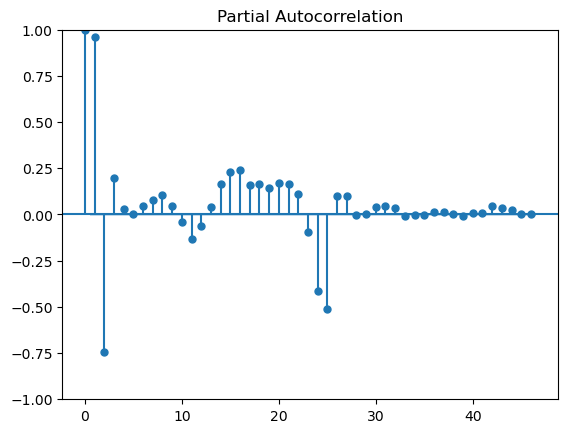

In [70]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Consumption'])
plt.show()

plot_pacf(df['Consumption'])
plt.show()

In [71]:
# Replace the values below with your determined p, d, q values
# p = 4  # AR component
# d =3  # Differencing
# q = 3  # MA component

# # Creating and training the ARIMA model
# model = ARIMA(df['Consumption'], order=(p, d, q))
# arima_model = model.fit()

# # Forecasting for the next 2 months (assuming daily frequency)
# forecast = arima_model.predict(start=len(df), end=len(df) + len(future_dates) - 1, typ='levels')

# # Visualizing the Forecast
# plt.figure(figsize=(12, 6))
# plt.plot(df.index, df['Consumption'], label='Actual')
# plt.plot(future_dates, forecast, label='Forecast')
# plt.title('ARIMA Forecast for Consumption')
# plt.legend()
# plt.show()


# Forecasting using Regression

Here we will prepare our data in train and test Xs and ys and use a XGB regressor to predict the target feature or our training part of the dataset.

In [72]:
# %%time

# # define our features and our target as separate arrays
# FEATURES = ["hour", "day_of_week", "quarter", "month", "year", "day_of_year"]
# TARGET = "Consumption"

# X_train = train[FEATURES]
# y_train = train[TARGET]

# X_test = test[FEATURES]
# y_test = test[TARGET]

# # define and XGB regressor, fit it on our train data and use it to predict our test data
# regressor = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)

# regressor.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
# regressorOutput = regressor.predict(X_test)

# prediction = pd.DataFrame(data=regressorOutput, index=X_test.index, columns=["prediction"])

# df = df.merge(prediction, how="left", left_index=True, right_index=True)

# # our predictions are at the end of the dataframe, so we should print that
# df.tail()

Let's calculate the error withe method that we defined before.

In [73]:
# # select the part of the data frame that is our test part
# testDf = df.tail(5000)

# yReal = testDf["Consumption"]
# yPredicted = testDf["prediction"]

# print(f"percentage error: {meanAbsolutErrorAaPercentage(yReal, yPredicted):.4f}")

In [74]:
df.tail()

,Consumption,hour,day_of_week,quarter,month,year,day_of_year
DateTime,,,,,,,
2023-03-12 19:00:00,6500,19,6,1,3,2023,71
2023-03-12 20:00:00,6471,20,6,1,3,2023,71
2023-03-12 21:00:00,6194,21,6,1,3,2023,71
2023-03-12 22:00:00,5708,22,6,1,3,2023,71
2023-03-12 23:00:00,5409,23,6,1,3,2023,71


In [75]:
df.head()

,Consumption,hour,day_of_week,quarter,month,year,day_of_year
DateTime,,,,,,,
2019-01-01 00:00:00,6352,0,1,1,1,2019,1
2019-01-01 01:00:00,6116,1,1,1,1,2019,1
2019-01-01 02:00:00,5873,2,1,1,1,2019,1
2019-01-01 03:00:00,5682,3,1,1,1,2019,1
2019-01-01 04:00:00,5557,4,1,1,1,2019,1


In [76]:
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV


# FEATURES = ["hour", "day_of_week", "quarter", "month", "year", "day_of_year"]
# TARGET = "Consumption"

# # Split data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(train[FEATURES], train[TARGET], test_size=0.2, random_state=42)

# # Define the parameter grid for grid search
# param_grid = {
#     'n_estimators': [100, 500, 1000],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'early_stopping_rounds': [20, 50, 100]
# }

# # Create an XGBoost regressor
# regressor = xgb.XGBRegressor()

# # Instantiate GridSearchCV
# grid_search = GridSearchCV(regressor, param_grid, cv=3, scoring='neg_mean_squared_error')

# # Fit the grid search to find the best hyperparameters
# grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)

# # Get the best hyperparameters
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

# # Create the final model using the best hyperparameters
# best_regressor = xgb.XGBRegressor(**best_params)

# # Fit the final model on the entire training data
# best_regressor.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=100)

# # Predict using the final model on the test set
# regressorOutput = best_regressor.predict(test[FEATURES])

# # Create a DataFrame with predictions
# prediction = pd.DataFrame(data=regressorOutput, index=test.index, columns=["prediction"])

# # Merge predictions with the original DataFrame
# df = df.merge(prediction, how="left", left_index=True, right_index=True)

# # Print the predictions
# print(df.tail())


In [77]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [78]:
from sklearn.model_selection import train_test_split

FEATURES = ["hour", "day_of_week", "quarter", "month", "year", "day_of_year"]
TARGET = "Consumption"

# Split data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(df[FEATURES], df[TARGET], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'early_stopping_rounds': [20, 50, 100]
}

# Create an XGBoost regressor
regressor = xgb.XGBRegressor()

# Instantiate GridSearchCV
grid_search = GridSearchCV(regressor, param_grid, cv=3, scoring='r2')

# Fit the grid search to find the best hyperparameters
grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Create the final model using the best hyperparameters
best_regressor = xgb.XGBRegressor(**best_params)

# Fit the final model on the entire training data
best_regressor.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)

# Predict using the final model on the test set
regressorOutput = best_regressor.predict(X_test)

# Create a DataFrame with predictions
prediction = pd.DataFrame(data=regressorOutput, index=X_test.index, columns=["prediction"])

# Merge predictions with the original DataFrame
df = df.merge(prediction, how="left", left_index=True, right_index=True)

# Print the predictions
print(df.tail())


[0]	validation_0-rmse:6728.22137
[99]	validation_0-rmse:2527.24433
[0]	validation_0-rmse:6728.24123
[99]	validation_0-rmse:2528.95982
[0]	validation_0-rmse:6728.20148
[99]	validation_0-rmse:2527.62584
[0]	validation_0-rmse:6728.22137
[100]	validation_0-rmse:2502.64527
[200]	validation_0-rmse:980.49454
[300]	validation_0-rmse:467.13185
[400]	validation_0-rmse:310.17083
[499]	validation_0-rmse:263.80716
[0]	validation_0-rmse:6728.24123
[100]	validation_0-rmse:2504.44557
[200]	validation_0-rmse:982.55618
[300]	validation_0-rmse:469.29597
[400]	validation_0-rmse:314.72720
[499]	validation_0-rmse:269.99565
[0]	validation_0-rmse:6728.20148
[100]	validation_0-rmse:2503.04993
[200]	validation_0-rmse:980.33602
[300]	validation_0-rmse:467.47064
[400]	validation_0-rmse:311.41780
[499]	validation_0-rmse:265.64556
[0]	validation_0-rmse:6728.22137
[100]	validation_0-rmse:2502.64527
[200]	validation_0-rmse:980.49454
[300]	validation_0-rmse:467.13185
[400]	validation_0-rmse:310.17083
[500]	validation_

In [79]:
import sklearn

In [80]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [81]:
results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Mean RMSE: {-mean_score} with Parameters: {params}")

Mean RMSE: 4.965300794224429 with Parameters: {'early_stopping_rounds': 20, 'learning_rate': 0.01, 'n_estimators': 100}
Mean RMSE: -0.9327906791687749 with Parameters: {'early_stopping_rounds': 20, 'learning_rate': 0.01, 'n_estimators': 500}
Mean RMSE: -0.956868441009694 with Parameters: {'early_stopping_rounds': 20, 'learning_rate': 0.01, 'n_estimators': 1000}
Mean RMSE: -0.9582285750344407 with Parameters: {'early_stopping_rounds': 20, 'learning_rate': 0.1, 'n_estimators': 100}
Mean RMSE: -0.9810389864253392 with Parameters: {'early_stopping_rounds': 20, 'learning_rate': 0.1, 'n_estimators': 500}
Mean RMSE: -0.984922321665012 with Parameters: {'early_stopping_rounds': 20, 'learning_rate': 0.1, 'n_estimators': 1000}
Mean RMSE: -0.9701471934915364 with Parameters: {'early_stopping_rounds': 20, 'learning_rate': 0.2, 'n_estimators': 100}
Mean RMSE: -0.9844143873435369 with Parameters: {'early_stopping_rounds': 20, 'learning_rate': 0.2, 'n_estimators': 500}
Mean RMSE: -0.9862206526937234 

In [82]:
# select the part of the data frame that is our test part
testDf = df.tail(5000)

yReal = testDf["Consumption"]
yPredicted = testDf["prediction"]

print(f"percentage error: {meanAbsolutErrorAaPercentage(yReal, yPredicted):.4f}")

percentage error: nan


Great, so the percentage error between the predicted and actual value is a little over 10%, **10.1803** precisily.

Now let's plot the prediction over the actual data, first for all the dataset and after for just a week.

In [83]:
df["prediction"]

DateTime
2019-01-01 00:00:00            NaN
2019-01-01 01:00:00            NaN
2019-01-01 02:00:00            NaN
2019-01-01 03:00:00            NaN
2019-01-01 04:00:00    5564.751465
                          ...     
2023-03-12 19:00:00            NaN
2023-03-12 20:00:00            NaN
2023-03-12 21:00:00            NaN
2023-03-12 22:00:00            NaN
2023-03-12 23:00:00            NaN
Name: prediction, Length: 36772, dtype: float32

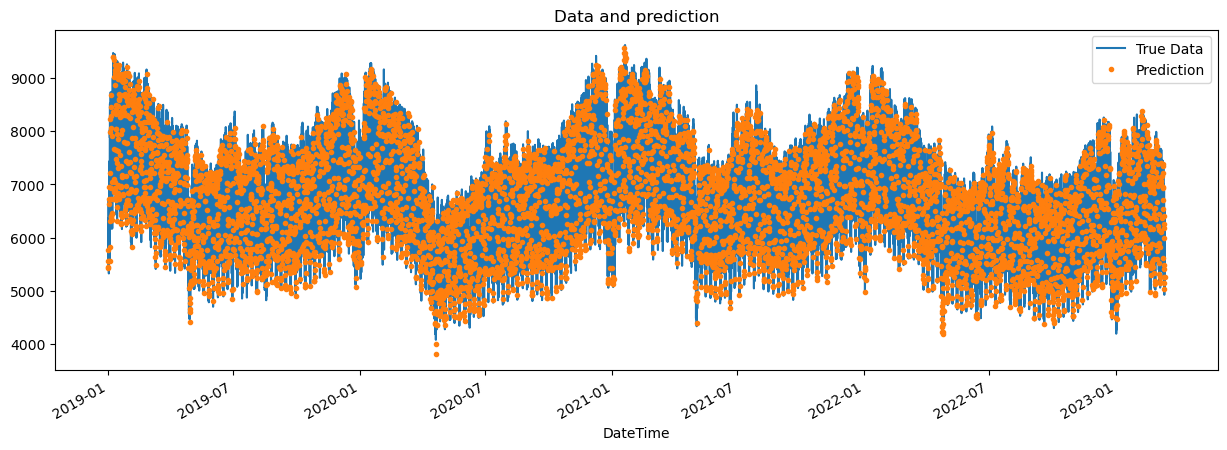

In [84]:
ax = df[[TARGET]].plot(figsize=(15,5))
df["prediction"].plot(ax=ax, style=".")
ax.legend(["True Data", "Prediction"])
ax.set_title("Data and prediction")
plt.show()

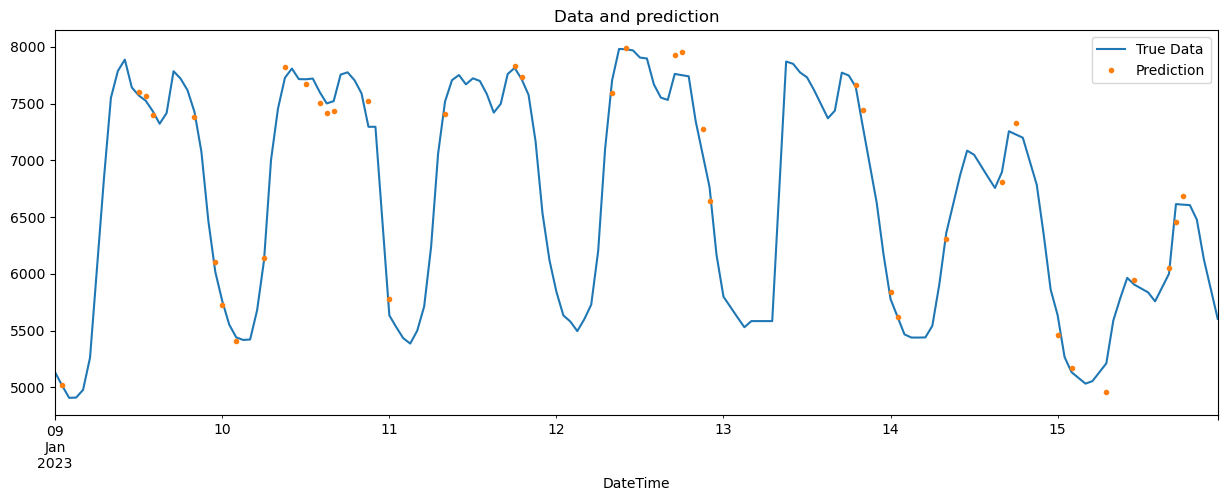

In [85]:
ax = df["2023-01-09 00:00:00" : "2023-01-15 23:59:59"][[TARGET]].plot(figsize=(15,5))
df["2023-01-09 00:00:00" : "2023-01-15 23:59:59"]["prediction"].plot(ax=ax, style=".")
ax.legend(["True Data", "Prediction"])
ax.set_title("Data and prediction")
plt.show()

So we plot the data for the entiere time range and also for just a week. The difference of about 10% is clearly visible but the regression model did pick up the pattern very well.

# Forecasting using Prophet

Prophet is a time series prediction library developed by Facebook/Meta. It is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality.

Prophet needs to be imported, as we did at the start of this notebook.

Prophets wan to have the date time column names as **ds**, and the target as **y**. So we will reset our index and rename our columns as needed.

We will do this for both our train and test dataframes.

In [86]:
prophetTrain = train.reset_index()
prophetTrain.drop(FEATURES, axis=1, inplace=True)
prophetTrain.rename(columns={"DateTime": "ds", "Consumption": "y"}, inplace=True)

prophetTrain.tail()

,ds,y
28008,2022-03-12 21:00:00,7458
28009,2022-03-12 22:00:00,6912
28010,2022-03-12 23:00:00,6377
28011,2022-03-13 00:00:00,6119
28012,2022-03-13 01:00:00,5864


In [87]:
prophetTest = test.reset_index()
prophetTest.drop(FEATURES, axis=1, inplace=True)
prophetTest.rename(columns={"DateTime": "ds", "Consumption": "y"}, inplace=True)

prophetTest.tail()

,ds,y
8754,2023-03-12 19:00:00,6500
8755,2023-03-12 20:00:00,6471
8756,2023-03-12 21:00:00,6194
8757,2023-03-12 22:00:00,5708
8758,2023-03-12 23:00:00,5409


Great, now let's create the Prophet object, fit it on the train data and use the test data for predicting.

In [88]:
%%time

prophetModel = Prophet()
prophetModel.fit(prophetTrain)

prophetPrediction = prophetModel.predict(prophetTest)

yRealProphet = test["Consumption"]
yPredictedProphet = prophetPrediction["yhat"]

print(f"prophet percentage error: {meanAbsolutErrorAaPercentage(yRealProphet, yPredictedProphet):.4f}")

20:11:05 - cmdstanpy - INFO - Chain [1] start processing
20:11:44 - cmdstanpy - INFO - Chain [1] done processing


prophet percentage error: 5.5591
CPU times: user 8.52 s, sys: 1.5 s, total: 10 s
Wall time: 50 s


The Prophet prediction is out of the box at an about 5% error, **5.5591** precisily.

Now let's also plot the predinction for the Prophet prediction. For the entiere data set and then for just a week.

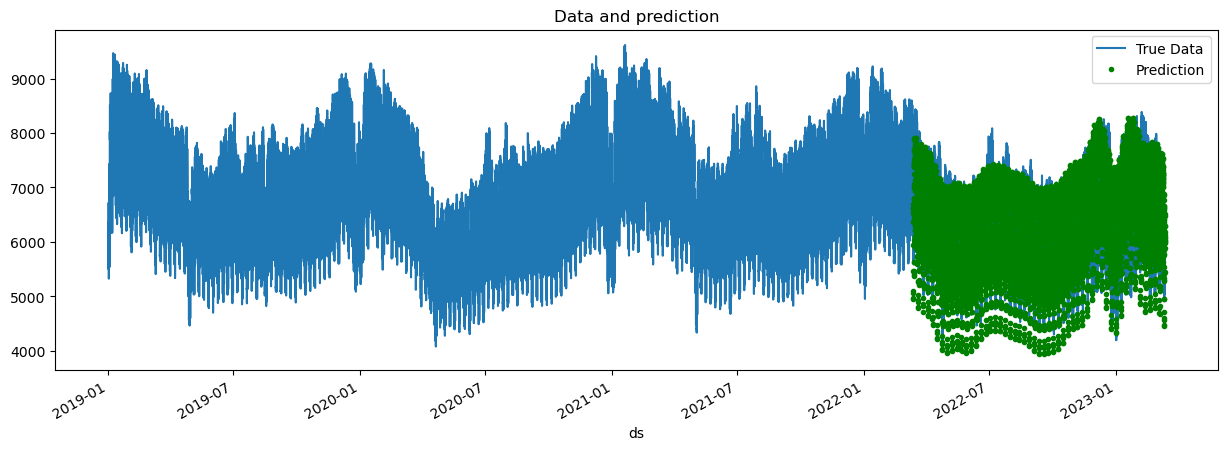

In [89]:
# in order to be optimaly plot the data we set it's ds (our initial DateTime) as the index
prophetPrediction = prophetPrediction.set_index("ds")

ax = df[[TARGET]].plot(figsize=(15,5))
prophetPrediction["yhat"].plot(ax=ax, style=".", color="g")
ax.legend(["True Data", "Prediction"])
ax.set_title("Data and prediction")
plt.show()

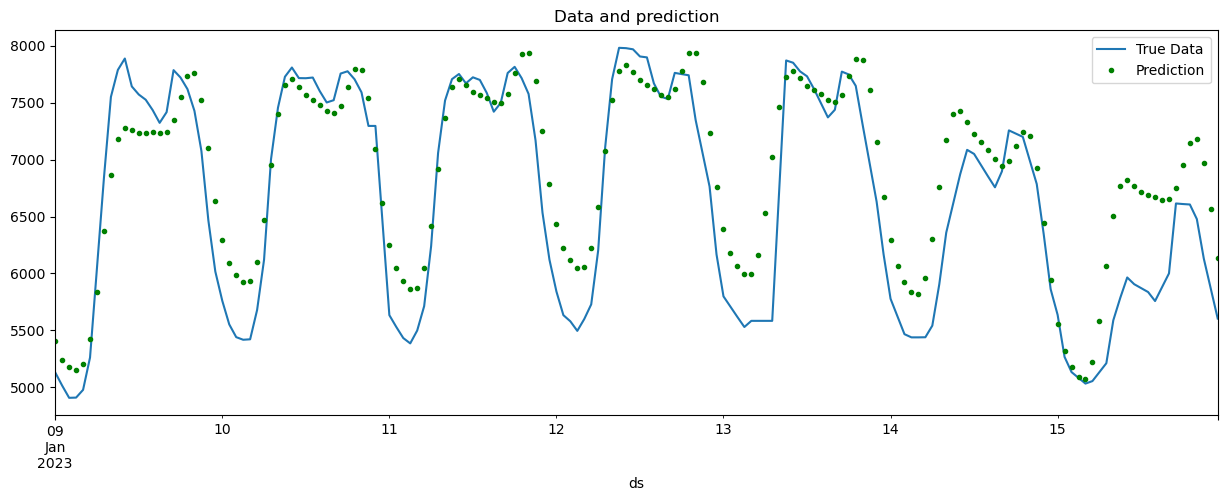

In [90]:
ax = df["2023-01-09 00:00:00" : "2023-01-15 23:59:59"][[TARGET]].plot(figsize=(15,5))
prophetPrediction["2023-01-09 00:00:00" : "2023-01-15 23:59:59"]["yhat"].plot(ax=ax, style=".", color="g")
ax.legend(["True Data", "Prediction"])
ax.set_title("Data and prediction")
plt.show()

So the Prophet prediction looks pretty good, after plotting it's easy to see that the trend is followed pretty well and we get a smaller error.

# Conclusion

So we did a time series forcast on an forecastable data set first using a standard regression technique and then with a modern purpuse build library.
Both solutions worked pretty well, especially considering they where out of the box, but Prophet really stands out.

# SVM Model

In [91]:
# Define your features and target variable
features = ["hour", "day_of_week", "quarter", "month", "year", "day_of_year"]
target = "Consumption"

# Split the data into training and testing sets
X_train_svm = train[features]
y_train_svm = train[target]

X_test_svm = test[features]
y_test_svm = test[target]


In [92]:
# from sklearn.svm import SVR

# # Initialize and train the SVM model
# svm_model = SVR(kernel='rbf', C=1000, gamma=0.1)  # Using an RBF kernel as an example
# svm_model.fit(X_train_svm, y_train_svm)


In [93]:
from sklearn.metrics import mean_absolute_error

# Predict using the trained SVM model
svm_predictions = svm_model.predict(X_test_svm)

# Calculate Mean Absolute Error (MAE)
svm_mae = mean_absolute_error(y_test_svm, svm_predictions)
print(f"SVM Mean Absolute Error: {svm_mae}")


NameError: name 'svm_model' is not defined

In [ ]:
from sklearn.metrics import mean_absolute_error

# Assuming you have trained and tested SVM and XGBoost models

# Calculate MAE for SVM and XGBoost
svm_mae = mean_absolute_error(y_test_svm, svm_predictions)  # Assuming you've predicted using SVM
xgb_mae = mean_absolute_error(y_test, yPredicted)  # Assuming you've predicted using XGBoost

# Compare MAE
print(f"SVM MAE: {svm_mae}")
print(f"XGBoost MAE: {xgb_mae}")

# Choose the model with the lower MAE (or any other relevant metric)
if svm_mae < xgb_mae:
    print("SVM performs better.")
else:
    print("XGBoost performs better.")


In [ ]:
df.index.date 

In [ ]:
df[df.index.month == 1]

In [ ]:
df.loc['2019-01-01']["Consumption"]

# Finish

You made it to the finish, thank you!

In [ ]:
weekly_data = df['Consumption'].resample('W').mean()
weekly_data

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(weekly_data.index, weekly_data.values, marker='o', linestyle='-')
plt.title('Weekly Consumption Trends')
plt.xlabel('Week')
plt.ylabel('Consumption')
plt.grid(True)
plt.show()

In [ ]:
hourly_data = df.groupby(['day_of_week', 'hour'])['Consumption'].mean().unstack()
hourly_data

In [ ]:
# Plotting hourly consumption for each day of the week
hourly_data.plot(kind='line', figsize=(10, 6))
plt.title('Hourly Consumption Patterns Across Days of the Week')
plt.xlabel('Hour')
plt.ylabel('Consumption')
plt.xticks(range(24))  # Set x-axis ticks to hours
plt.legend(title='Day of the Week', loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
# Selecting the last 21 days of data
last_21_days = df.tail(21 * 24)  # 21 days * 24 hours per day

# Grouping by hour and summing the consumption
hourly_sum = last_21_days.groupby('hour')['Consumption'].sum()
hourly_sum

In [ ]:

# Creating a histogram
plt.figure(figsize=(10, 6))
plt.bar(hourly_sum.index, hourly_sum.values, width=0.5)
plt.xlabel('Hour of the Day')
plt.ylabel('Sum of Hourly Consumption')
plt.title('Sum of Hourly Consumption for Last 21 Days')
plt.xticks(range(24))  # Set x-axis ticks to hours (0-23)
plt.grid(axis='y')
plt.show()

In [ ]:
import seaborn as sns

corr_data = df.tail(24*400)
corr_data

In [ ]:
corr_data = df.tail(24*400).iloc[0:,0:-1]

correlation_matrix = corr_data.corr()

# Plotting the correlation matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()